# Introduction to Data Science and Machine Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

## Regularisation and Overfitting issues Homework

The aim of this homework is to check whether a given model overfits and apply strategies to avoid such behaviour.

### Import libraries

In [1]:
# Import libraries we will need in the following
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV,  ShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# set plot size
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15

### Read dataset

We are going to read a simple dataset.
This is the famous titanic dataset, you already met.

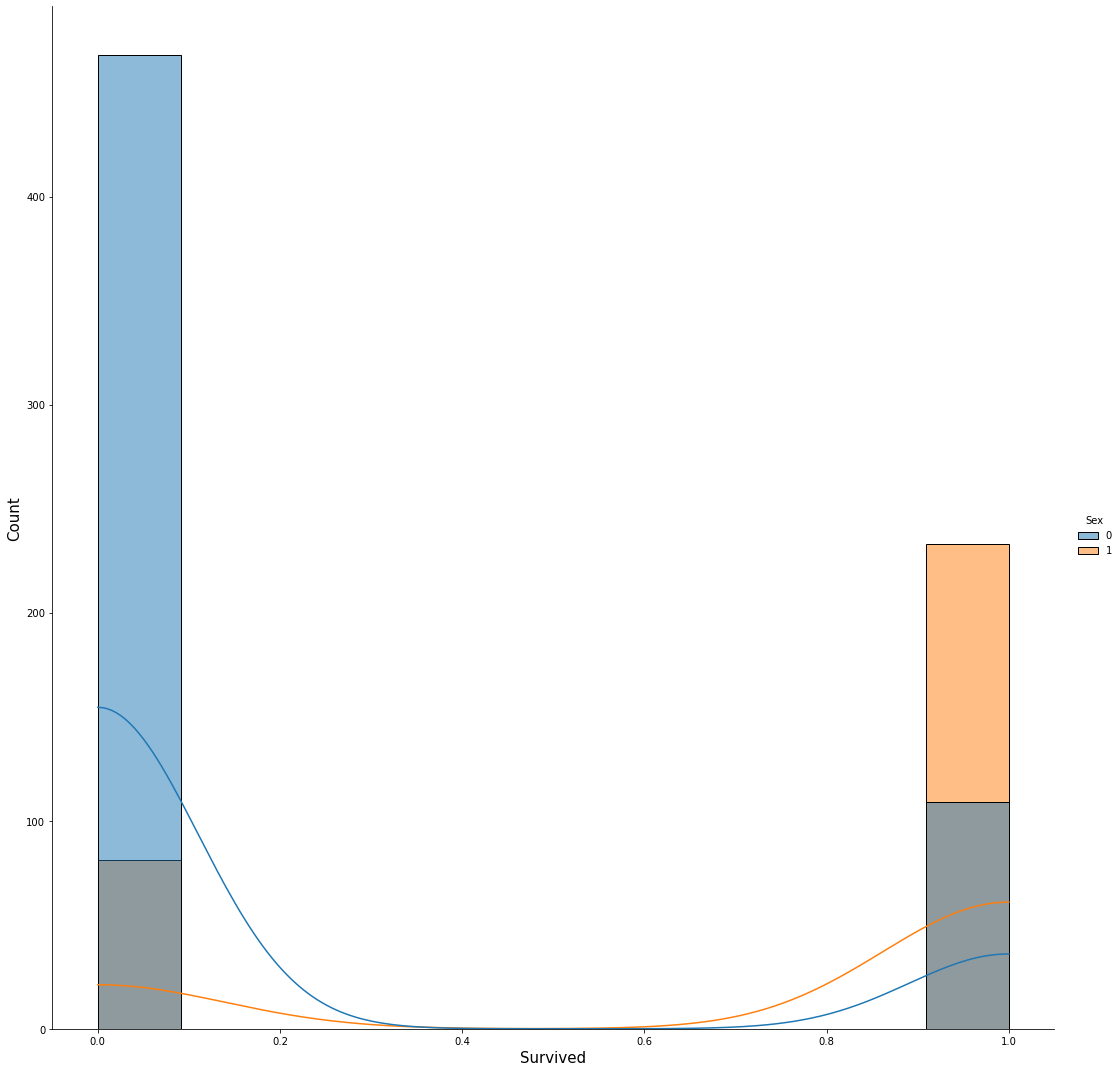

In [2]:
df = pd.read_csv('http://bit.ly/kaggletrain')
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

sns.displot(data=df, x="Survived", kde=True, hue="Sex", height=15);

In [3]:
features = ['Pclass', 'Fare', 'Sex', 'Parch']
X = df[features]
y = df['Survived']

## Gini Impurity and Entropy

We have seen that in algorithm based on trees, we look for the best split. 
The term “best” split means that after split, the two branches are more “ordered” than any other possible split.
How do we define more ordered? 
It depends on which metric we choose.
In general, there are two types of metric: _Gini impurity_ and _entropy_. 
These metrics are disorder metrics, that is the smaller these metrics are, the more “ordered” the dataset is.

$$ \mathcal{G} = 1 - \sum_j p^2_j \, . $$

$$ \mathcal{S} = - \sum_j p_j \log p_j \, . $$

The difference between the two metrics is pretty subtle. 
To learn more, you may read this [post](https://quantdare.com/decision-trees-gini-vs-entropy/). 
In most applications, both metric behave similarly. 

Complete the code below to calculate each metric.

In [4]:
def gini_impurity(y):
    """Function to calculate Gini impurity."""
    m = y.shape[0]
    cnts = dict(zip(*np.unique(y, return_counts = True)))
    impurity = 1 - sum((cnt/m)**2 for cnt in cnts.values())
    return impurity

def entropy(y):
    """Function to calculate Entropy."""
    m = y.shape[0]
    cnts = dict(zip(*np.unique(y, return_counts = True)))
    entr = - sum((cnt/m)*np.log2(cnt/m) for cnt in cnts.values())
    return entr

### Train and test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Homework Assignements

1. Define and train decision tree models, 
2. Play with hyperparameters and calculate the suitable metrics in order to verify whether the model overfits or underfits data.
3. Plot learning curves of your models by using the utils function `plot_learning_curve`.

---

### Your Work


Conisdering that classes are unbalanced the evaluation metric will be f1 weighted.
<br>
Let's have a look at the dataset before training our model

In [6]:
X_train.info()
print(X_train.isnull().sum())
X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  712 non-null    int64  
 1   Fare    712 non-null    float64
 2   Sex     712 non-null    int64  
 3   Parch   712 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 27.8 KB
Pclass    0
Fare      0
Sex       0
Parch     0
dtype: int64


,Pclass,Fare,Sex,Parch
331,1,28.5000,0,0
733,2,13.0000,0,0
382,3,7.9250,0,0
704,3,7.8542,0,0
813,3,31.2750,1,2
...,...,...,...,...
106,3,7.6500,1,0
270,1,31.0000,0,0
860,3,14.1083,0,0
435,1,120.0000,1,2


The dataset is clean, now let's see features distirbutions

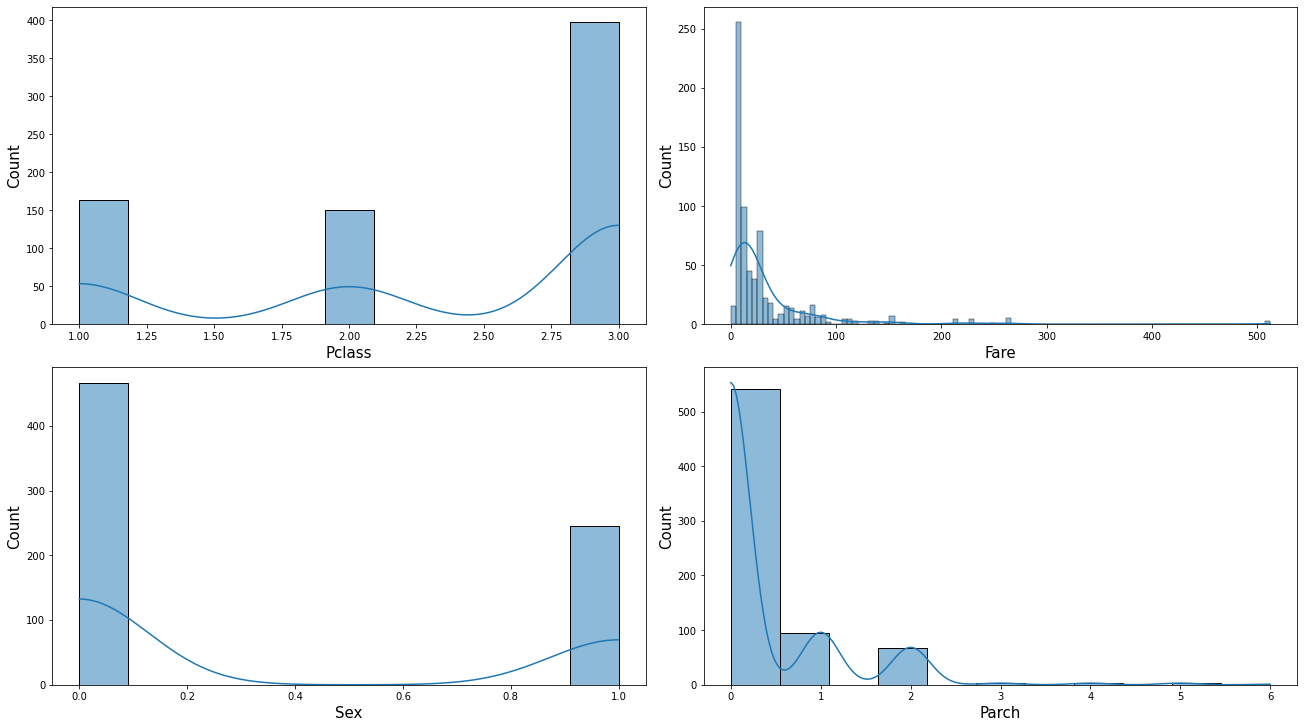

In [7]:
fig, axes = plt.subplots(2,2, constrained_layout = True)
for col, ax in zip(X_train.columns, axes.ravel()):
    sns.histplot(X_train[col], kde = True, ax = ax)

The only continuous feature is fare, which contains some outliers.
<br>
For now we won't touch the dataframe, but after a first evaluation of the model outliers will be removed.
<br>
Now let's see correlations

<AxesSubplot:>

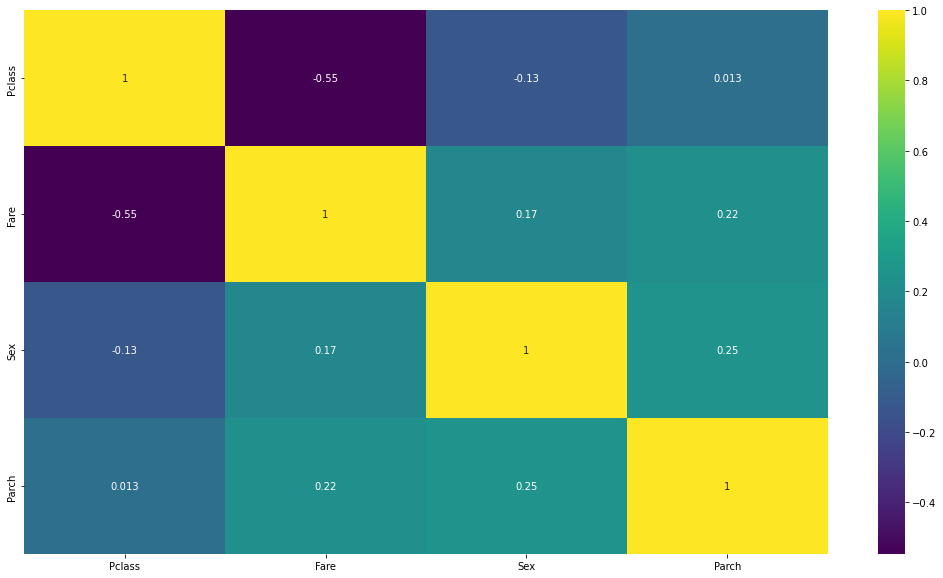

In [8]:
corr = X_train.corr()
sns.heatmap(corr, annot = True, cmap = 'viridis')

The only high correlation is between fare and pclass, let's plot these two

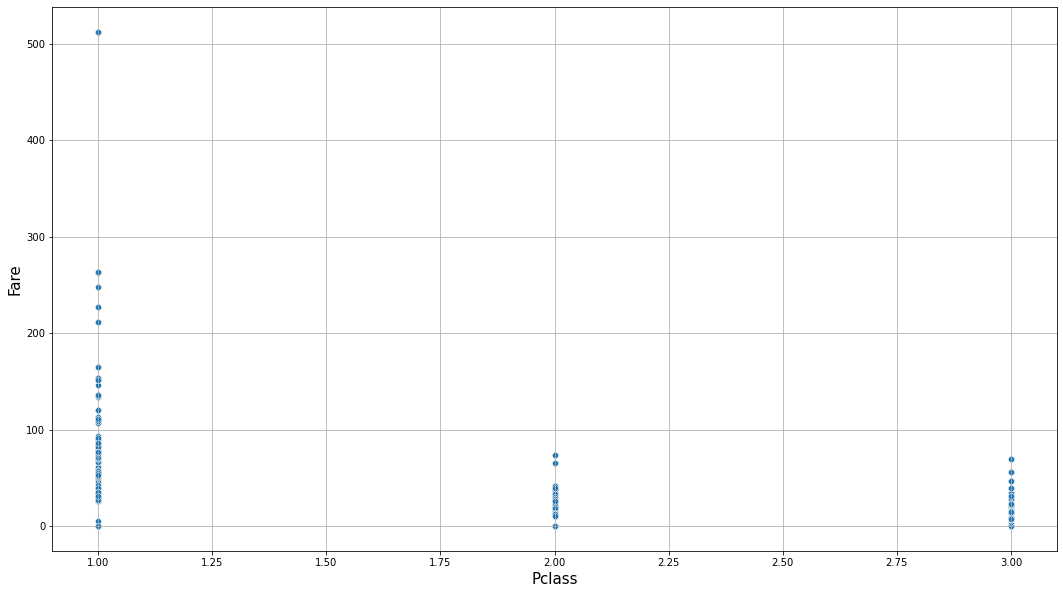

In [9]:
sns.scatterplot(data=X_train, x='Pclass', y='Fare')
plt.grid()

It shouldn't be a problem if we leave this way the dataset
<br>
It's time to evaluate the model, we will use a cross validation with 50 splits to show the distributions of the score on this dataset

Mean f1 score = 0.8051331714464374 | score deviation = 0.025115628428954522


Text(0, 0.5, 'Counts')

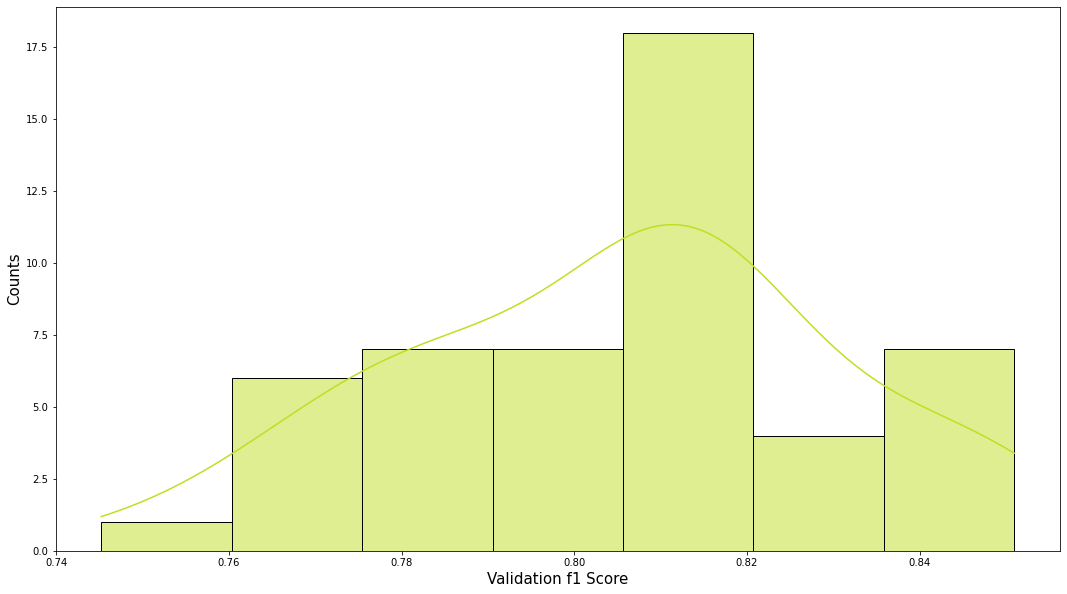

In [10]:
dt = DecisionTreeClassifier()
cv = ShuffleSplit(n_splits=50, test_size=0.2) 
scores = cross_val_score(dt, X_train, y_train, scoring='f1_weighted', cv=cv, n_jobs = -1)
print(f"Mean f1 score = {scores.mean()} | score deviation = {scores.std()}")

sns.histplot(scores, kde = True, color=np.random.random(3))
plt.xlabel('Validation f1 Score')
plt.ylabel('Counts')

Let's see if model overfits plotting learning curves

In [11]:
df_size = [i/10 for i in range(1,11)]

dt = DecisionTreeClassifier()
data_size, train_score, valid_score = learning_curve(dt,
                                                     X_train, y_train,
                                                     train_sizes=df_size,
                                                     cv = cv, n_jobs=-1,
                                                     scoring='f1_weighted')

In [12]:
#Setting some parameters to show the standard deviation in the graph
def plot_curves(data_size, train_score, valid_score, ax):
    
    train_mean = train_score.mean(axis = 1)
    valid_mean = valid_score.mean(axis = 1)
    upper_train = train_mean + train_score.std(axis = 1)
    upper_valid = valid_mean + valid_score.std(axis = 1)
    lower_train = train_mean - train_score.std(axis = 1)
    lower_valid = valid_mean - valid_score.std(axis = 1)

    sns.lineplot(x=data_size, y = train_mean, label = 'train score', ax = ax)
    sns.lineplot(x=data_size, y = valid_mean, label = 'valid score', ax = ax)
    ax.fill_between(data_size, lower_train, upper_train, alpha=.2)
    ax.fill_between(data_size, lower_valid, upper_valid, alpha=.2)
    ax.grid()
    ax.set_xlabel('data size')
    ax.set_ylabel('$F_1$ score')
    
    return ax

<AxesSubplot:xlabel='data size', ylabel='$F_1$ score'>

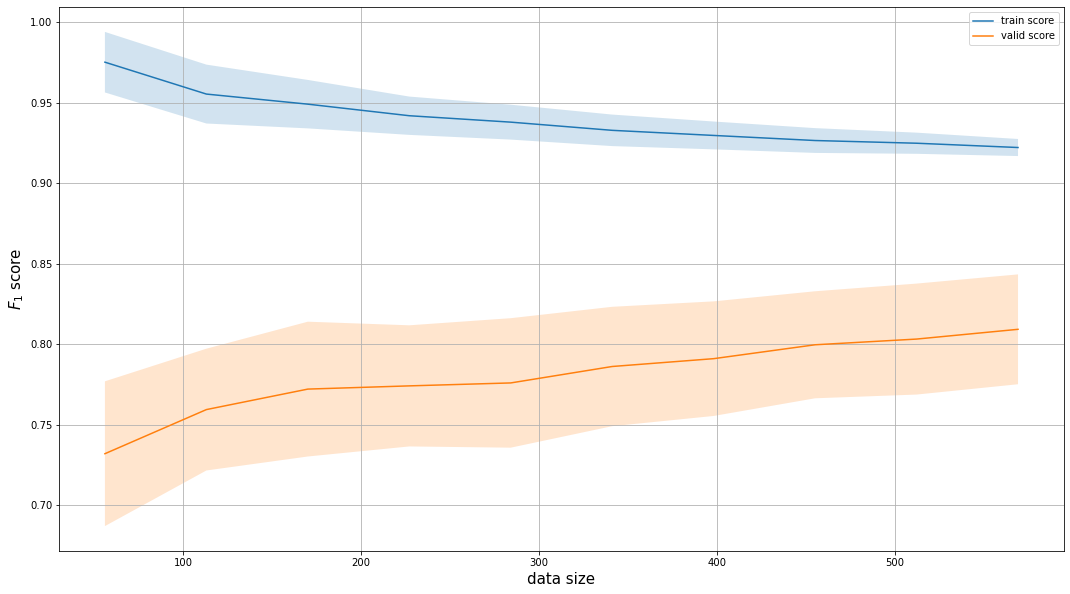

In [13]:
fig, ax = plt.subplots()
plot_curves(data_size, train_score, valid_score, ax)

Clearly the model is overfitting, there is margin for improvement
<br>
Let's try with a grid search

In [14]:
params = {'max_depth':[i for i in range(1,7)],
          'min_samples_split':[i*2 for i in range(1,7)],
          'max_leaf_nodes':[i for i in range(2,7)],
          'criterion':['gini','entropy']
         }

grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring = 'f1_weighted', cv = cv, n_jobs=-1)
grid.fit(X_train, y_train)
best_tree = grid.best_estimator_
print(grid.best_params_)

{'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2}


Mean f1 score = 0.7974625610022974 | score deviation = 0.03212120965499004


Text(0, 0.5, 'Counts')

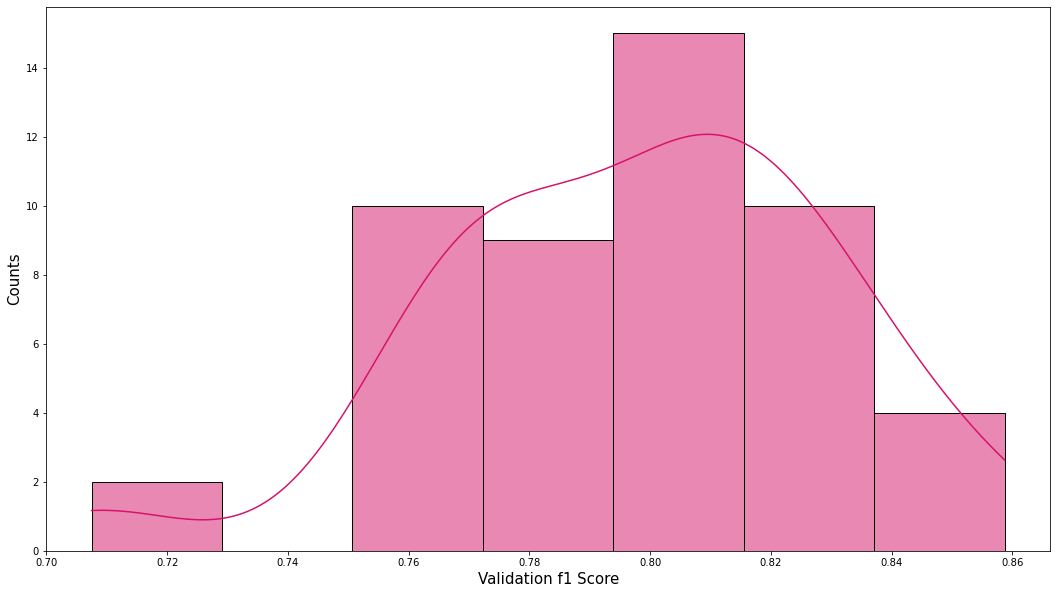

In [15]:
scores = cross_val_score(best_tree, X_train, y_train, scoring='f1_weighted', cv=cv, n_jobs = -1)
print(f"Mean f1 score = {scores.mean()} | score deviation = {scores.std()}")

sns.histplot(scores, kde = True, color=np.random.random(3))
plt.xlabel('Validation f1 Score')
plt.ylabel('Counts')

The score's distribution is sligthly more skewed to the right, there is a small imporvement in the performance
<br>
Let's see if it is overfitting

In [16]:
data_size, train_score2, valid_score2 = learning_curve(best_tree,
                                                     X_train, y_train,
                                                     train_sizes=df_size,
                                                     cv = cv, n_jobs=-1,
                                                     scoring='f1_weighted')

<AxesSubplot:xlabel='data size', ylabel='$F_1$ score'>

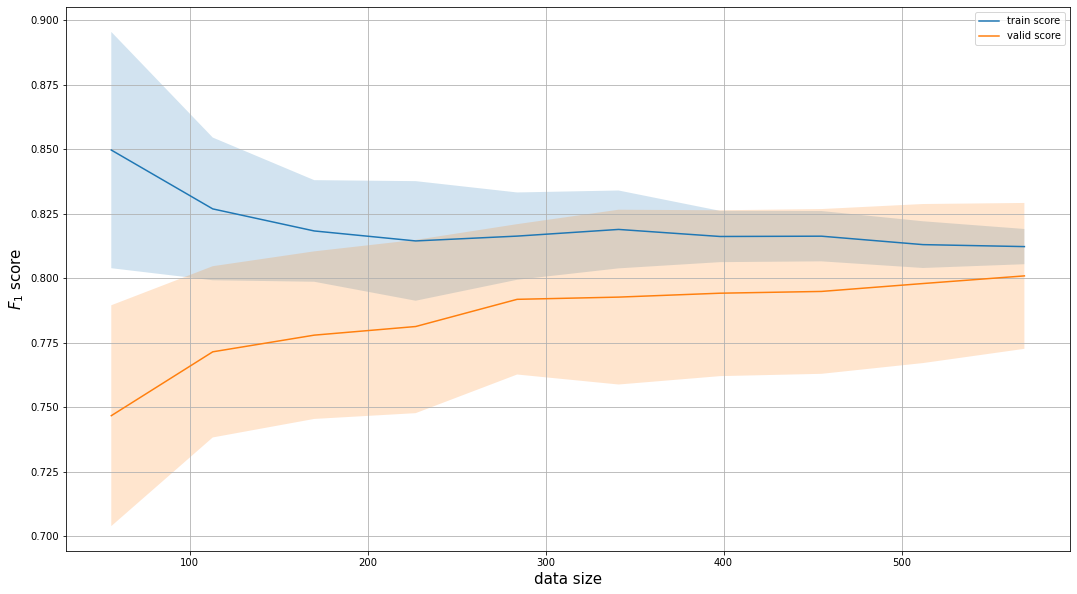

In [17]:
fig, ax = plt.subplots()
plot_curves(data_size, train_score2, valid_score2, ax)

Now the model is in an optimal condition
<br>
To have a better visualization of the improvement, let's plot learning curves side to side before and after tuning of hyperparameters

<AxesSubplot:xlabel='data size', ylabel='$F_1$ score'>

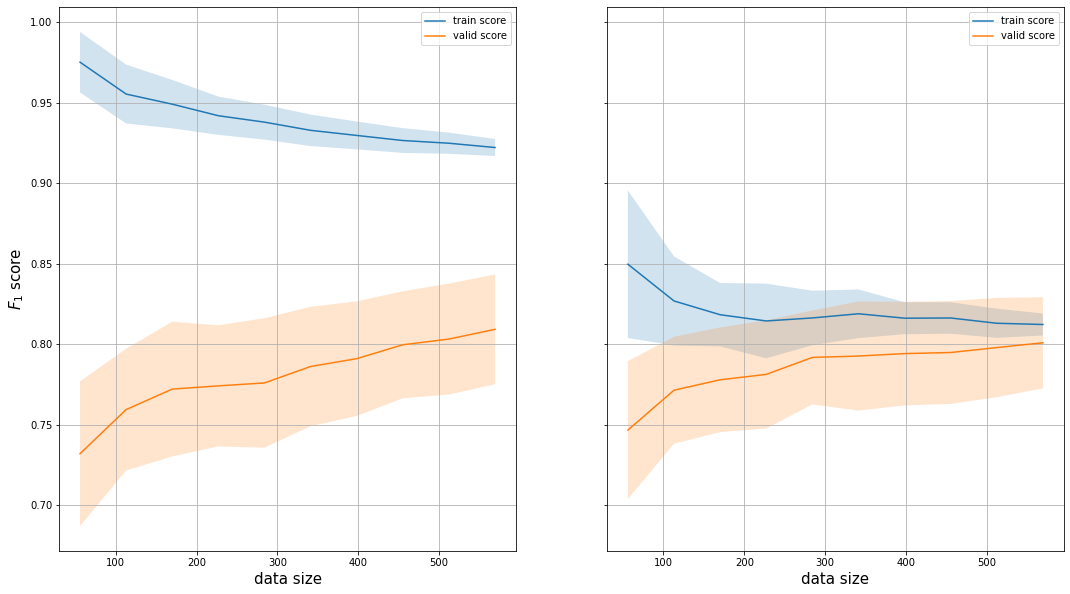

In [18]:
fig, ax = plt.subplots(1, 2, sharey=True)
plot_curves(data_size, train_score, valid_score, ax[0])
plot_curves(data_size, train_score2, valid_score2, ax[1])

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



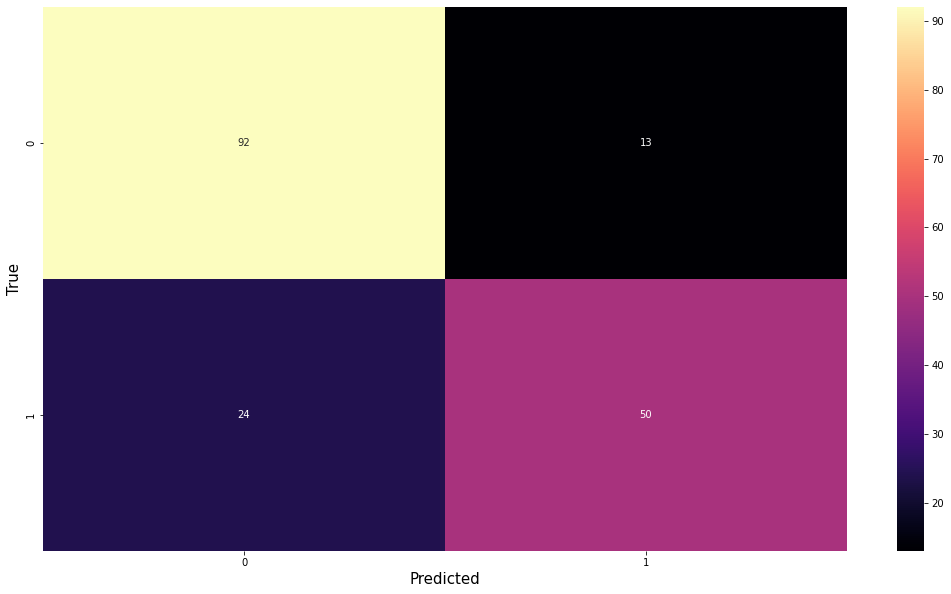

In [19]:
pred = best_tree.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=pred)
sns.heatmap(cm, annot = True, cmap = 'magma')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_true=y_test, y_pred=pred))

We surely reduced overfitting, but we didn't increase the overall performance.
<br>
Looking at the recall we can say that there are a lot of false negatives, so people who died are more missclassified
<br>
Let's remove the outliers in X_train, we will drop rows with 'fare' higher than 150

In [20]:
idx = X_train['Fare'].values >= 150
X_train_drop = X_train.drop(index = X_train.index[idx])
y_train_drop = y_train.drop(index = X_train.index[idx])

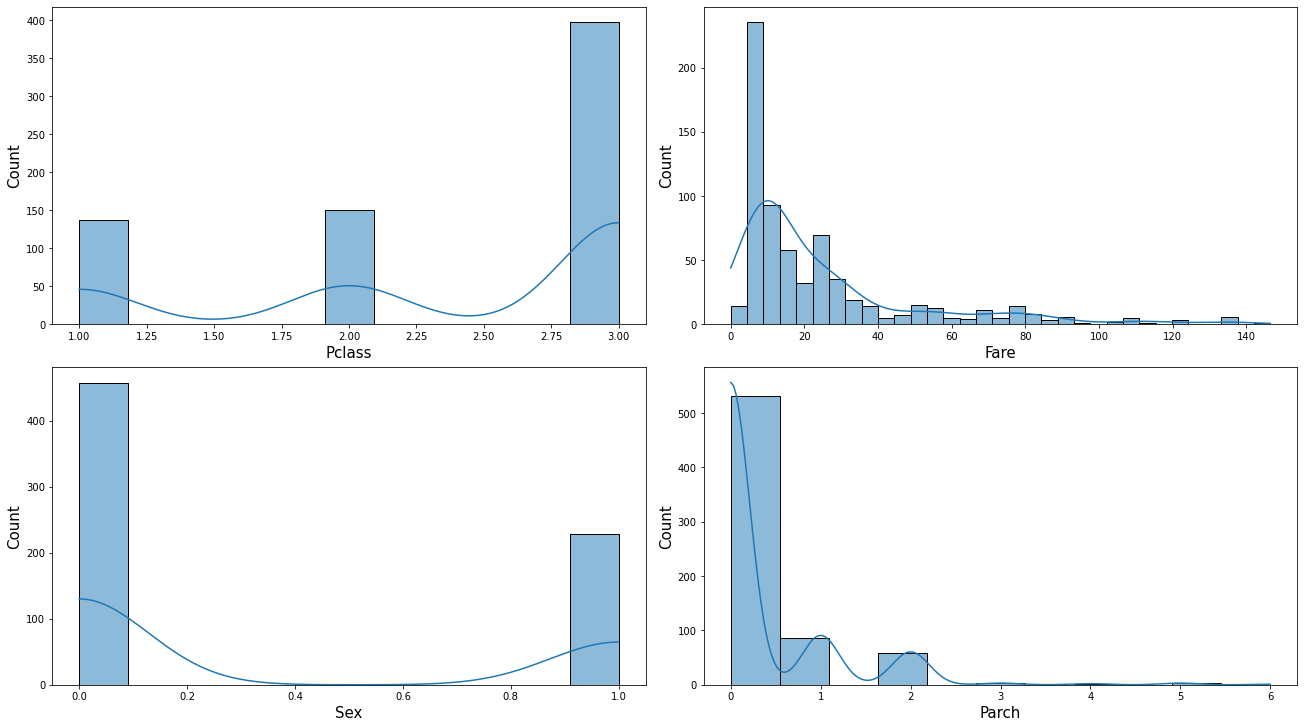

In [21]:
fig, axes = plt.subplots(2,2, constrained_layout = True)
for col, ax in zip(X_train_drop.columns, axes.ravel()):
    sns.histplot(X_train_drop[col], kde = True, ax = ax)

In [22]:
df_size = [i/10 for i in range(1,11)]

dt = DecisionTreeClassifier()
data_size, train_score, valid_score = learning_curve(dt,
                                                     X_train_drop, y_train_drop,
                                                     train_sizes=df_size,
                                                     cv = cv, n_jobs=-1,
                                                     scoring='f1_weighted')

<AxesSubplot:xlabel='data size', ylabel='$F_1$ score'>

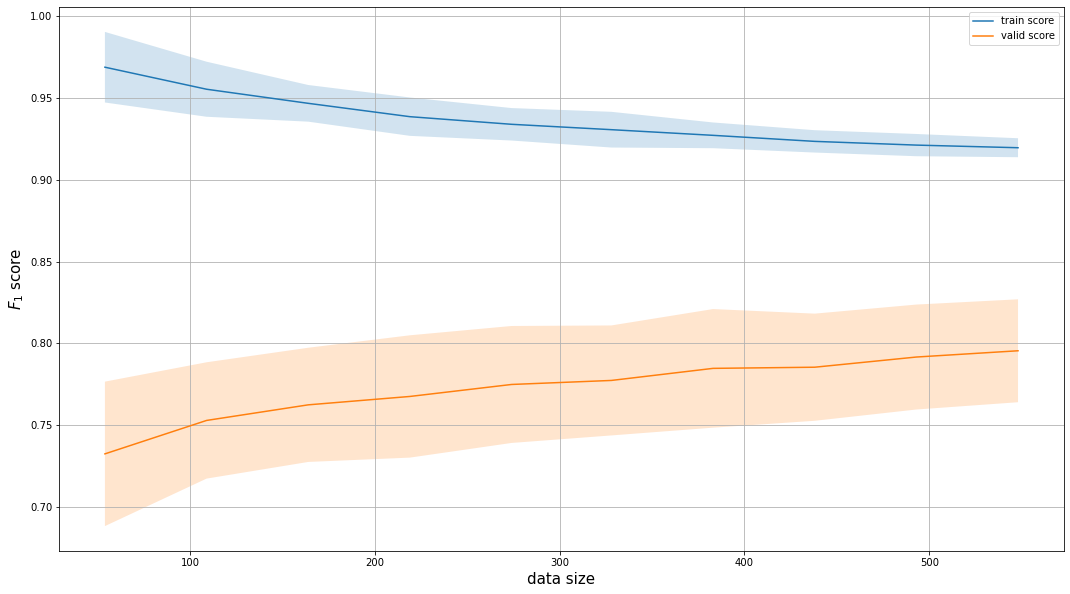

In [23]:
fig, ax = plt.subplots()
plot_curves(data_size, train_score, valid_score, ax)

The model is overfitting, let's tune hyperparameters

In [24]:
params = {'max_depth':[i for i in range(1,7)],
          'min_samples_split':[i*2 for i in range(1,7)],
          'max_leaf_nodes':[i for i in range(2,7)],
          'criterion':['gini','entropy']
         }

grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring = 'f1_weighted', cv = cv, n_jobs=-1)
grid.fit(X_train_drop, y_train_drop)
best_tree = grid.best_estimator_
print(grid.best_params_)

{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2}


Mean f1 score = 0.8072077387572584 | score deviation = 0.03160583112983609


Text(0, 0.5, 'Counts')

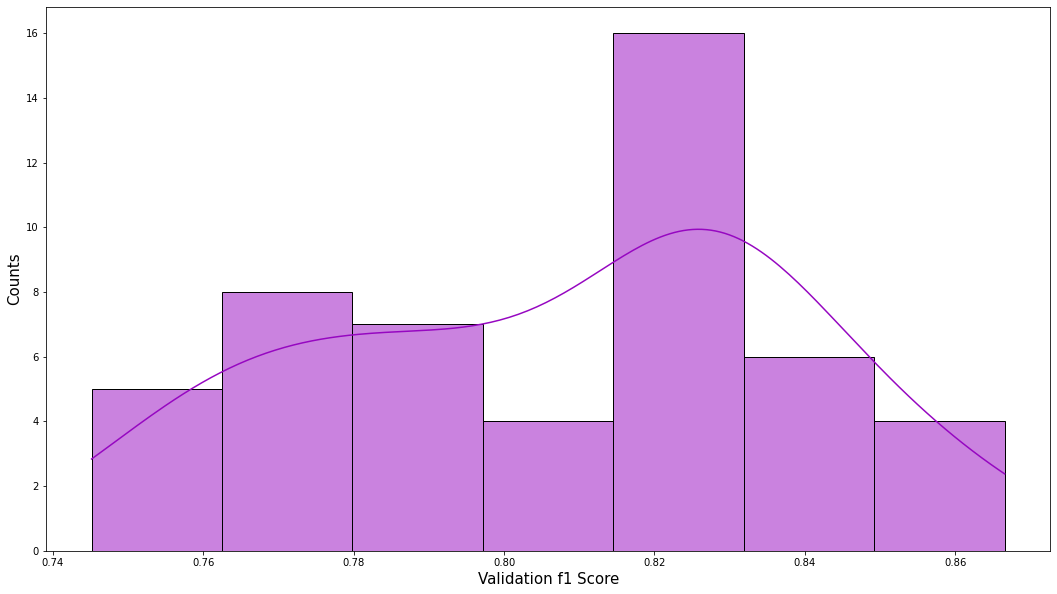

In [25]:
scores = cross_val_score(best_tree, X_train_drop, y_train_drop, scoring='f1_weighted', cv=cv, n_jobs = -1)
print(f"Mean f1 score = {scores.mean()} | score deviation = {scores.std()}")

sns.histplot(scores, kde = True, color=np.random.random(3))
plt.xlabel('Validation f1 Score')
plt.ylabel('Counts')

In [26]:
data_size, train_score2, valid_score2 = learning_curve(best_tree,
                                                     X_train_drop, y_train_drop,
                                                     train_sizes=df_size,
                                                     cv = cv, n_jobs=-1,
                                                     scoring='f1_weighted')

<AxesSubplot:xlabel='data size', ylabel='$F_1$ score'>

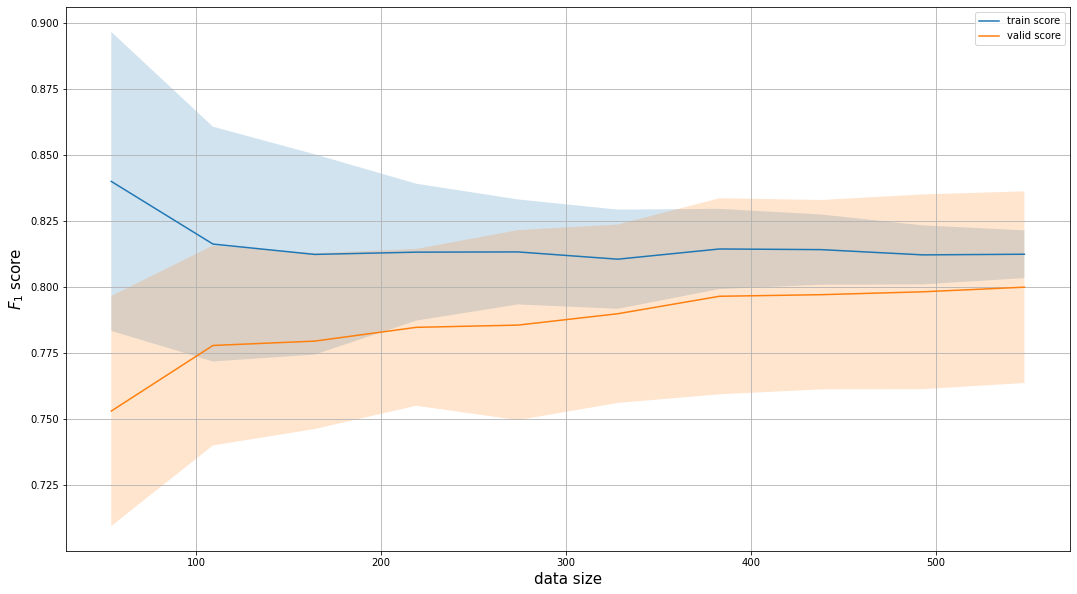

In [27]:
fig, ax = plt.subplots()
plot_curves(data_size, train_score2, valid_score2, ax)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



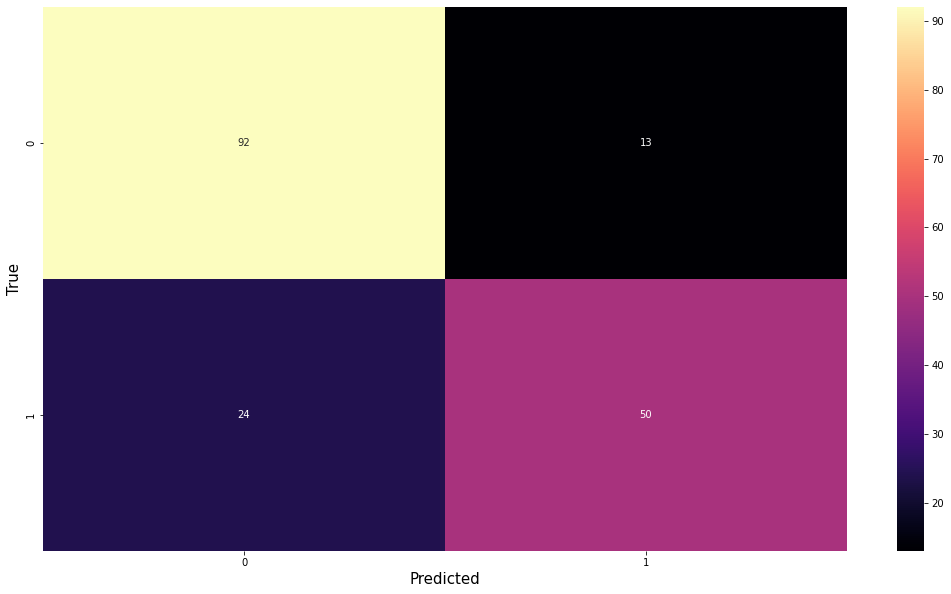

In [28]:
pred = best_tree.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=pred)
sns.heatmap(cm, annot = True, cmap = 'magma')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_true=y_test, y_pred=pred))

Removing outliers didn't improve the performance, but in both case tuning hyperparameters reduced overfitting as we wanted